In [1]:
import rbm_3way as rbm3
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from matplotlib import pyplot as plt

# Testing _prop_helper() and get_delta_products() against brute force methods

### Generate data: v1s, v2s, w

In [96]:
def generate_v(n_v, mu_v, sig_v):
    v = np.random.normal(mu_v,sig_v,n_v)
    return v


n_v1 = 10
n_h = 25
n_v2 = 14
n_samples = 50

v1s = []
v2s = []

for n in range(n_samples):
    v1 = generate_v(n_v1,np.arange(n_v1),np.ones(n_v1))
    v1 = v1.astype(np.float32)
    v1s.append(v1)
    
    v2 = generate_v(n_v2,np.arange(n_v2),np.ones(n_v2))
    v2 = v2.astype(np.float32)
    v2s.append(v2)
    
v1s = np.stack(v1s)
v2s = np.stack(v2s)

w = np.random.randn(n_v1*n_v2*n_h).reshape(n_v1,n_h,n_v2)

v2s[0].T

array([  1.81343496,   0.60982805,   2.83924222,   3.94800234,
         2.81000185,   4.28106976,   7.2762599 ,   7.56497049,
         6.99160671,   9.98215103,  12.36700058,  12.26105881,
        14.55602837,  13.7905035 ], dtype=float32)

In [106]:
print(w.shape)
print(v1s.shape)
print(v2s.shape)

(10, 25, 14)
(50, 10)
(50, 14)


### _prop_helper()

In [107]:
def _prop_helper(a, b, perm):
    """ perm specifies matrix orientation"""
    wt = tf.transpose(w,perm=perm)
    wtv = tf.einsum('ijk,kl->ijl',wt,tf.transpose(a))
    wtvt = tf.transpose(wtv,perm=[2,0,1])
    wtvtv = tf.matmul(wtvt,tf.expand_dims(b,axis=-1))
    wtvtvs = tf.reduce_sum(wtvtv,axis=-1)
    return wtvtvs

In [108]:
with tf.Session() as s:
    res = s.run(_prop_helper(v1s.astype(float), v2s.astype(float), [1, 2, 0]))

In [109]:
res.shape

(50, 25)

In [110]:
def bruteforce_batch(v1,v2,n_h,w):
    
    assert v1.shape[0] == v2.shape[0]

    I = v1.shape[1]
    J = n_h
    K = v2.shape[1]
    S = v1.shape[0]

    h = np.zeros(S*n_h).reshape(S,-1)

    for s in range(S):
        for i in range(I):
            for j in range(J):
                for k in range(K):
                    h[s][j] = h[s][j] + v1[s][i]*v2[s][k]*w[i,j,k]
                
    return h

In [111]:
h = bruteforce_batch(v1s,v2s,n_h,w)
h.shape

(50, 25)

In [112]:
(h-res)**2

array([[  2.16807317e-11,   2.62532460e-11,   1.96194893e-11, ...,
          1.01917348e-12,   1.66796581e-10,   3.86202758e-11],
       [  5.25824744e-12,   3.01622583e-10,   3.40159917e-11, ...,
          1.34789913e-10,   2.89088034e-11,   9.49883306e-11],
       [  2.86375531e-12,   2.06009111e-10,   7.78229076e-10, ...,
          1.43844926e-10,   3.60614891e-14,   7.66360594e-11],
       ..., 
       [  8.80784309e-11,   1.88007778e-11,   2.33635678e-10, ...,
          1.74253981e-10,   3.01229329e-10,   3.97669275e-10],
       [  4.91109806e-11,   6.19856911e-11,   5.98837412e-11, ...,
          1.27563433e-11,   7.72310311e-13,   3.95310983e-10],
       [  8.32379837e-11,   8.39775868e-11,   1.01015943e-10, ...,
          3.08506657e-10,   1.94935996e-13,   4.90491751e-12]])

We see that there are some numerical differences between the two methods, but that they agree to significant levels. I'm not investigating why at this point, or which one is more accurate; my first assumption would be that the vectorized operation would be more accurate due to looping over intermediate sums in the brute force method, which would be another advantage of vectorization. Success!

### get_delta_products()

In [113]:
def get_delta_products(v1,h,v2):
    v1 = tf.expand_dims(v1,axis=-1)
    h = tf.expand_dims(h,axis=-1)
    v2 = tf.expand_dims(v2,axis=-1)
    prod = tf.matmul(v1,tf.transpose(h, perm=[0,2,1]))
    prod = tf.transpose(tf.expand_dims(prod,-1), perm=[1,0,2,3])
    prod = tf.einsum('ijkl,jmn->ijkn',prod,tf.transpose(v2,perm=[0,2,1]))
    prod = tf.transpose(prod,perm=[1,0,2,3])
    return tf.reduce_mean(prod,axis=0)

In [114]:
with tf.Session() as s:
    res = s.run(get_delta_products(v1s.astype(float), h.astype(float), v2s.astype(float)))

In [115]:
def bruteforce_delta(v1,v2,h):
    
    assert v1s.shape[0] == v2s.shape[0] == h.shape[0]
    
    I = v1.shape[1]
    J = h.shape[1]
    K = v2.shape[1]
    S = v1.shape[0]
    
    d = np.zeros(S*I*J*K).reshape(S,I,J,K)
    
    for s in range(S):
        for i in range(I):
            for j in range(J):
                for k in range(K):
                    d[s][i][j][k] = v1[s][i]*h[s][j]*v2[s][k]
                    
    d = np.mean(d,0)
    print(d.shape)
    
    return d
    

bi = bruteforce_delta(v1s,v2s,h)

(10, 25, 14)


In [116]:
(bi - res)**2

array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       ..., 
       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0., 

In this case we see the vectorized op and brute force method agree completely. Success!

# Testing the RBM Class

In [2]:
def generate_v(n_v, mu_v, sig_v):
    v = np.random.normal(mu_v,sig_v,n_v)
    return v


n_v1 = 10
n_v2 = 14
n_h = 25
n_samples = 50

v1s = []
v2s = []

for n in range(n_samples):
    v1 = generate_v(n_v1,np.arange(n_v1),np.ones(n_v1))
    v1 = v1.astype(np.float32)
    v1s.append(v1)
    
    v2 = generate_v(n_v2,np.arange(n_v2),np.ones(n_v2))
    v2 = v2.astype(np.float32)
    v2s.append(v2)
    
v1s = np.stack(v1s)
v2s = np.stack(v2s)

v2s[0].T

array([  0.39215791,   1.3268801 ,   2.64564061,   3.05266237,
         4.17035675,   5.73675299,   3.59056616,   6.08932686,
         9.37555599,   9.11422157,  12.39131641,  10.41462803,
        12.14718437,  12.8730402 ], dtype=float32)


squared reconstruction error: 71219038650368.0: 100%|██████████| 100/100 [11:39<00:00,  9.56s/it]


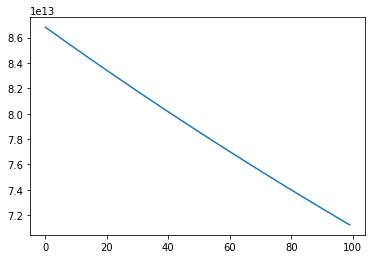

In [5]:
with tf.Session() as sess:
    RBM = rbm3.RBM(name='rbm', v1_size=n_v1, h_size=n_h, v2_size=n_v2)
    init = tf.global_variables_initializer()
    sess.run(init)
    costs = []
    pbar = tqdm(range(100))
    for i in pbar:
        w = sess.run(RBM.pcd_k(v1s, v2s, learning_rate=0.001, k=1, persistant=False))
        cost, _, _ = sess.run(RBM.reconstruction_error(v1s,v2s))
        costs.append(cost)
        pbar.set_description('squared reconstruction error: {}'.format(cost))
        if i % 20 == 0:
            #plt.hist(w[0],bins=20)
            #plt.title(i)
            #plt.show()
            pass
    plt.plot(range(len(costs)),costs)
    plt.show()

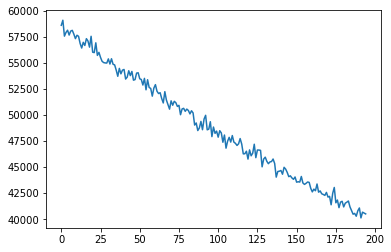

In [4]:
plt.plot(range(len(costs)),costs)
plt.show()